# Qats & Doqs

In [1]:
# On importe les librairies dont on aura besoin pour ce tp
import pennylane as qml
from pennylane import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Sensor

In [2]:
@qml.template
def sensor(datas, wires):
    qml.RX(datas[0], wires=wires[0])
    if len(datas) == 3:
        qml.RY(datas[1], wires=wires[0])
        qml.RZ(datas[2], wires=wires[0])
    else:
        qml.RZ(datas[1], wires=wires[0])

## Classifier

In [3]:
@qml.template
def classifier(params, wires):
    # qml.RZ(params, wires=wires[0])
    # qml.RY(params, wires=wires[0])
    n_qubits = len(wires)
    n_rotations = len(params)
    n_layers = n_rotations // n_qubits

    if n_rotations % n_qubits != 0:
        raise Exception("Last layer is incomplete, not all qubits are rotated")

    # Alternating layers of unitary rotations on every qubit followed by a
    # ring cascade of CNOTs.
    for layer_idx in range(n_layers):
        layer_params = params[layer_idx * n_qubits: layer_idx * n_qubits + n_qubits, :]
        qml.broadcast(qml.Rot, wires, pattern="single", parameters=layer_params)
        if n_qubits > 1:
            qml.broadcast(qml.CNOT, wires, pattern="ring")

## Init data sensor

In [64]:
"""
   To use your dataset just change the csv file call 
"""
csv_training = pd.read_csv('datas/training_data_xz.csv', header=None)
print("Training data set shape", csv_training.shape)
print("Training data set:") 
print(csv_training[:10])
print("\n")

csv_testing = pd.read_csv('datas/testing_data_xz.csv', header=None)
print("Testing data set shape", csv_testing.shape)
print("Testing data set:") 
print(csv_testing[:10])

"""
   To use your dataset just change the csv file call 
"""
#csv_training = pd.read_csv('datas/training_data_xyz_normal.csv', header=None)
#print("Training data set shape", csv_training.shape)
#print("Training data set:") 
#print(csv_training[:10])
#print("\n")

#csv_testing = pd.read_csv('datas/testing_data_xyz_normal.csv', header=None)
#print("Testing data set shape", csv_testing.shape)
#print("Testing data set:") 
#print(csv_testing[:10])

Training data set shape (1999, 3)
Training data set:
          0         1    2
0  1.310305  5.265838  qat
1  1.807496  4.473977  doq
2  1.828074  4.368759  doq
3  2.250279  2.510487  doq
4  0.809598  1.625995  qat
5  0.835273  3.986925  qat
6  1.596440  5.485240  doq
7  0.917452  0.198001  qat
8  0.761617  4.235470  qat
9  1.333237  1.454580  qat


Testing data set shape (499, 2)
Testing data set:
          0         1
0  1.796278  5.127016
1  0.220950  5.766171
2  0.736258  5.166474
3  0.508544  0.854920
4  3.028223  2.815891
5  0.311861  5.269300
6  2.295929  0.453769
7  1.340906  1.582118
8  0.557699  5.657507
9  3.121631  5.701430


'\n   To use your dataset just change the csv file call \n'

## Training

In [49]:
print("##################################################################\n"
      "# TRAINING")
"""
    Variables :
    data_training : the xy // xyz data for only 1 qubit
    label_training : the label for only 1 qubit
    n_layers : deep level
    weights : the angle for the classifier
"""

dev = qml.device('default.qubit', wires=1, shots=1)
n_qubits = len(dev.wires)
n_layers = 2
weights = np.random.uniform(low=-np.pi, high=np.pi, size=(n_layers * n_qubits, 3))
opt = qml.GradientDescentOptimizer(stepsize=0.01)
error_rate = 0

if csv_training.shape[1] == 3:
    prediction = [[], [], []]
else:
    prediction = [[], [], [], []]

#for i in range(len(csv_training[0])):
for i in range(1000):
    if csv_training.shape[1] == 3:
        data_training = [csv_training[0][i], csv_training[1][i]]
        label_training = csv_training[2][i]
    else:
        data_training = [csv_training[0][i], csv_training[1][i], csv_training[2][i]]
        label_training = csv_training[3][i]


    @qml.qnode(dev)
    def entire_circuit(datas, params):
        sensor(datas, wires=[0])
        classifier(params, wires=dev.wires)
        return qml.sample(qml.PauliZ(0))
    

    result = entire_circuit(data_training, weights)
    prob = result
    
    
    @qml.qnode(dev)
    def optimizer_circuit(params):
        classifier(params, wires=dev.wires)
        return qml.expval(qml.PauliZ(0))
    
    def cost(x):
        return optimizer_circuit(x)
    
    
    if (prob == -1 and label_training != "doq") or (prob == 1 and label_training != "qat"):
        steps = 100
        for i in range(steps):
            weights = opt.step(cost, weights)
            prob = entire_circuit(data_training, weights)
            
            if (i + 1) % 10 == 0:
                print("Cost after step {:5d}: {: .7f} -> {}".format(i + 1, prob, label_training))
                      
            if (prob == -1 and label_training == "doq") or (prob == 1 and label_training == "qat"):
                break
             
    if (prob == -1 and label_training != "doq") or (prob == 1 and label_training != "qat"):
        error_rate += 1
        
    # Graph and check error
    prediction[0].append(data_training[0])
    prediction[1].append(data_training[1])
    if csv_training.shape[1] == 3:
        prediction[2].append(prob)
    else:
        prediction[2].append(data_training[2])
        prediction[3].append(prob)

print("\nTraining done !")

##################################################################
# TRAINING
Cost after step    10:  1.0000000 -> doq
Cost after step    10: -1.0000000 -> qat
Cost after step    20: -1.0000000 -> qat
Cost after step    30: -1.0000000 -> qat
Cost after step    10: -1.0000000 -> qat
Cost after step    10:  1.0000000 -> doq
Cost after step    20:  1.0000000 -> doq
Cost after step    30:  1.0000000 -> doq
Cost after step    40:  1.0000000 -> doq
Cost after step    50:  1.0000000 -> doq
Cost after step    60:  1.0000000 -> doq
Cost after step    70:  1.0000000 -> doq
Cost after step    80:  1.0000000 -> doq
Cost after step    90:  1.0000000 -> doq
Cost after step   100:  1.0000000 -> doq
Cost after step    10: -1.0000000 -> qat
Cost after step    20: -1.0000000 -> qat
Cost after step    30: -1.0000000 -> qat
Cost after step    40: -1.0000000 -> qat
Cost after step    50: -1.0000000 -> qat
Cost after step    60: -1.0000000 -> qat
Cost after step    70: -1.0000000 -> qat
Cost after step    8

Cost after step    40:  1.0000000 -> doq
Cost after step    50:  1.0000000 -> doq
Cost after step    60:  1.0000000 -> doq
Cost after step    70:  1.0000000 -> doq
Cost after step    80:  1.0000000 -> doq
Cost after step    90:  1.0000000 -> doq
Cost after step   100:  1.0000000 -> doq
Cost after step    10:  1.0000000 -> doq
Cost after step    20:  1.0000000 -> doq
Cost after step    30:  1.0000000 -> doq
Cost after step    40:  1.0000000 -> doq
Cost after step    50:  1.0000000 -> doq
Cost after step    60:  1.0000000 -> doq
Cost after step    70:  1.0000000 -> doq
Cost after step    10: -1.0000000 -> qat
Cost after step    20: -1.0000000 -> qat
Cost after step    30: -1.0000000 -> qat
Cost after step    40: -1.0000000 -> qat
Cost after step    50: -1.0000000 -> qat
Cost after step    60: -1.0000000 -> qat
Cost after step    70: -1.0000000 -> qat
Cost after step    80: -1.0000000 -> qat
Cost after step    90: -1.0000000 -> qat
Cost after step   100: -1.0000000 -> qat
Cost after step 

Cost after step    90:  1.0000000 -> doq
Cost after step   100:  1.0000000 -> doq
Cost after step    10:  1.0000000 -> doq
Cost after step    20:  1.0000000 -> doq
Cost after step    30:  1.0000000 -> doq
Cost after step    40:  1.0000000 -> doq
Cost after step    50:  1.0000000 -> doq
Cost after step    60:  1.0000000 -> doq
Cost after step    70:  1.0000000 -> doq
Cost after step    80:  1.0000000 -> doq
Cost after step    90:  1.0000000 -> doq
Cost after step   100:  1.0000000 -> doq
Cost after step    10:  1.0000000 -> doq
Cost after step    20:  1.0000000 -> doq
Cost after step    30:  1.0000000 -> doq
Cost after step    40:  1.0000000 -> doq
Cost after step    50:  1.0000000 -> doq
Cost after step    60:  1.0000000 -> doq
Cost after step    70:  1.0000000 -> doq
Cost after step    80:  1.0000000 -> doq
Cost after step    90:  1.0000000 -> doq
Cost after step   100:  1.0000000 -> doq
Cost after step    10: -1.0000000 -> qat
Cost after step    20: -1.0000000 -> qat
Cost after step 

Cost after step   100:  1.0000000 -> doq
Cost after step    10:  1.0000000 -> doq
Cost after step    20:  1.0000000 -> doq
Cost after step    30:  1.0000000 -> doq
Cost after step    40: -1.0000000 -> doq
Cost after step    10: -1.0000000 -> qat
Cost after step    20: -1.0000000 -> qat
Cost after step    10: -1.0000000 -> qat
Cost after step    20: -1.0000000 -> qat
Cost after step    30: -1.0000000 -> qat
Cost after step    10:  1.0000000 -> doq
Cost after step    20:  1.0000000 -> doq
Cost after step    30:  1.0000000 -> doq
Cost after step    40:  1.0000000 -> doq
Cost after step    50:  1.0000000 -> doq
Cost after step    10:  1.0000000 -> doq
Cost after step    20:  1.0000000 -> doq
Cost after step    10: -1.0000000 -> qat
Cost after step    10: -1.0000000 -> qat
Cost after step    20: -1.0000000 -> qat
Cost after step    30: -1.0000000 -> qat
Cost after step    40: -1.0000000 -> qat
Cost after step    50: -1.0000000 -> qat
Cost after step    60: -1.0000000 -> qat
Cost after step 

Cost after step    40:  1.0000000 -> doq
Cost after step    50:  1.0000000 -> doq
Cost after step    60:  1.0000000 -> doq
Cost after step    70:  1.0000000 -> doq
Cost after step    80:  1.0000000 -> doq
Cost after step    90:  1.0000000 -> doq
Cost after step   100:  1.0000000 -> doq
Cost after step    10: -1.0000000 -> qat
Cost after step    10: -1.0000000 -> qat
Cost after step    20: -1.0000000 -> qat
Cost after step    30: -1.0000000 -> qat
Cost after step    40: -1.0000000 -> qat
Cost after step    50: -1.0000000 -> qat
Cost after step    10:  1.0000000 -> doq
Cost after step    20:  1.0000000 -> doq
Cost after step    30:  1.0000000 -> doq
Cost after step    40:  1.0000000 -> doq
Cost after step    50:  1.0000000 -> doq
Cost after step    60:  1.0000000 -> doq
Cost after step    70:  1.0000000 -> doq
Cost after step    80:  1.0000000 -> doq
Cost after step    90:  1.0000000 -> doq
Cost after step   100:  1.0000000 -> doq
Cost after step    10: -1.0000000 -> qat
Cost after step 

Cost after step    80: -1.0000000 -> qat
Cost after step    90: -1.0000000 -> qat
Cost after step   100: -1.0000000 -> qat
Cost after step    10: -1.0000000 -> qat
Cost after step    10: -1.0000000 -> qat
Cost after step    10:  1.0000000 -> doq
Cost after step    10:  1.0000000 -> doq
Cost after step    10:  1.0000000 -> doq
Cost after step    20:  1.0000000 -> doq
Cost after step    30:  1.0000000 -> doq
Cost after step    40:  1.0000000 -> doq
Cost after step    50:  1.0000000 -> doq
Cost after step    60:  1.0000000 -> doq
Cost after step    70:  1.0000000 -> doq
Cost after step    80:  1.0000000 -> doq
Cost after step    90:  1.0000000 -> doq
Cost after step   100:  1.0000000 -> doq
Cost after step    10:  1.0000000 -> doq
Cost after step    20:  1.0000000 -> doq
Cost after step    30:  1.0000000 -> doq
Cost after step    40:  1.0000000 -> doq
Cost after step    50:  1.0000000 -> doq
Cost after step    60:  1.0000000 -> doq
Cost after step    70:  1.0000000 -> doq
Cost after step 

Cost after step   100:  1.0000000 -> doq
Cost after step    10:  1.0000000 -> doq
Cost after step    20:  1.0000000 -> doq
Cost after step    30:  1.0000000 -> doq
Cost after step    40:  1.0000000 -> doq
Cost after step    50:  1.0000000 -> doq
Cost after step    60:  1.0000000 -> doq
Cost after step    70:  1.0000000 -> doq
Cost after step    80:  1.0000000 -> doq
Cost after step    90:  1.0000000 -> doq
Cost after step   100:  1.0000000 -> doq
Cost after step    10: -1.0000000 -> qat
Cost after step    10: -1.0000000 -> qat
Cost after step    20: -1.0000000 -> qat
Cost after step    10:  1.0000000 -> doq
Cost after step    10: -1.0000000 -> qat
Cost after step    10:  1.0000000 -> doq
Cost after step    20:  1.0000000 -> doq
Cost after step    30:  1.0000000 -> doq
Cost after step    40:  1.0000000 -> doq
Cost after step    50:  1.0000000 -> doq
Cost after step    60:  1.0000000 -> doq
Cost after step    70:  1.0000000 -> doq
Cost after step    80:  1.0000000 -> doq
Cost after step 

Cost after step    90:  1.0000000 -> doq
Cost after step   100:  1.0000000 -> doq
Cost after step    10:  1.0000000 -> doq
Cost after step    20:  1.0000000 -> doq
Cost after step    30:  1.0000000 -> doq
Cost after step    40:  1.0000000 -> doq
Cost after step    50:  1.0000000 -> doq
Cost after step    60:  1.0000000 -> doq
Cost after step    70: -1.0000000 -> doq
Cost after step    10: -1.0000000 -> qat
Cost after step    20: -1.0000000 -> qat
Cost after step    30: -1.0000000 -> qat
Cost after step    40: -1.0000000 -> qat
Cost after step    50: -1.0000000 -> qat
Cost after step    60: -1.0000000 -> qat
Cost after step    10:  1.0000000 -> doq
Cost after step    20:  1.0000000 -> doq
Cost after step    30:  1.0000000 -> doq
Cost after step    40:  1.0000000 -> doq
Cost after step    50:  1.0000000 -> doq
Cost after step    60:  1.0000000 -> doq
Cost after step    70:  1.0000000 -> doq
Cost after step    80:  1.0000000 -> doq
Cost after step    90:  1.0000000 -> doq
Cost after step 

Cost after step    80:  1.0000000 -> doq
Cost after step    90:  1.0000000 -> doq
Cost after step   100:  1.0000000 -> doq
Cost after step    10:  1.0000000 -> doq
Cost after step    20:  1.0000000 -> doq
Cost after step    30:  1.0000000 -> doq
Cost after step    40:  1.0000000 -> doq
Cost after step    50:  1.0000000 -> doq
Cost after step    60:  1.0000000 -> doq
Cost after step    70:  1.0000000 -> doq
Cost after step    80:  1.0000000 -> doq
Cost after step    90:  1.0000000 -> doq
Cost after step   100:  1.0000000 -> doq
Cost after step    10:  1.0000000 -> doq
Cost after step    10: -1.0000000 -> qat
Cost after step    10:  1.0000000 -> doq
Cost after step    20:  1.0000000 -> doq
Cost after step    30:  1.0000000 -> doq
Cost after step    10:  1.0000000 -> doq
Cost after step    20:  1.0000000 -> doq
Cost after step    30:  1.0000000 -> doq
Cost after step    40:  1.0000000 -> doq
Cost after step    50:  1.0000000 -> doq
Cost after step    60:  1.0000000 -> doq
Cost after step 

## Graph and check error

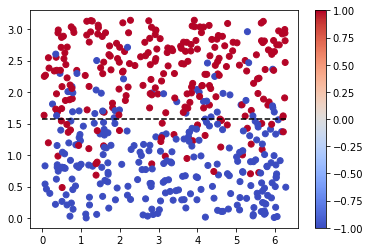

Error rate : 22.645 %


In [63]:
if len(prediction) == 3:
    plt.scatter(prediction[1], prediction[0], c=prediction[2], cmap="coolwarm")
    plt.plot([0,2*np.pi], [np.pi/2, np.pi/2], linestyle='--', c='#000000')
    plt.colorbar()
else:
    fig = plt.figure().gca(projection='3d')
    fig.scatter(prediction[0], prediction[1], prediction[2], c=prediction[3], cmap="coolwarm")
plt.show()

print("Error rate : {} %".format(round(error_rate / len(prediction[0]) * 100, 3)))

# Testing

In [51]:
print("##################################################################\n"
      "# Testing")
"""
    Variables :
    data_training : the xy // xyz data for only 1 qubit
    label_training : the label for only 1 qubit
    n_layers : deep level
    weights : the angle for the classifier
"""

dev = qml.device('default.qubit', wires=1, shots=1)

if csv_testing.shape[1] == 2:
    prediction = [[], [], []]
else:
    prediction = [[], [], [], []]

for i in range(len(csv_testing[0])):
#for i in range(20):
    if csv_testing.shape[1] == 2:
        data_testing = [csv_testing[0][i], csv_testing[1][i]]
    else:
        data_testing = [csv_testing[0][i], csv_testing[1][i], csv_testing[2][i]]


    @qml.qnode(dev)
    def entire_circuit(datas, params):
        sensor(datas, wires=[0])
        classifier(params, wires=dev.wires)
        return qml.sample(qml.PauliZ(0))
    

    result = entire_circuit(data_testing, weights)
    prob = result
        
    
    # Graph and check error
    prediction[0].append(data_testing[0])
    prediction[1].append(data_testing[1])
    if csv_testing.shape[1] == 2:
        prediction[2].append(prob)
    else:
        prediction[2].append(data_testing[2])
        prediction[3].append(prob)

print("\nTesting done !")

##################################################################
# Testing

Testing done !


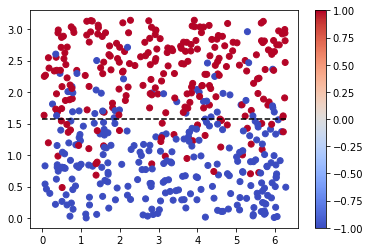

In [52]:
if len(prediction) == 3:
    plt.scatter(prediction[1], prediction[0], c=prediction[2], cmap="coolwarm")
    plt.plot([0,2*np.pi], [np.pi/2, np.pi/2], linestyle='--', c='#000000')
    plt.colorbar()
else:
    fig = plt.figure().gca(projection='3d')
    fig.scatter(prediction[0], prediction[1], prediction[2], c=prediction[3], cmap="coolwarm")
plt.show()